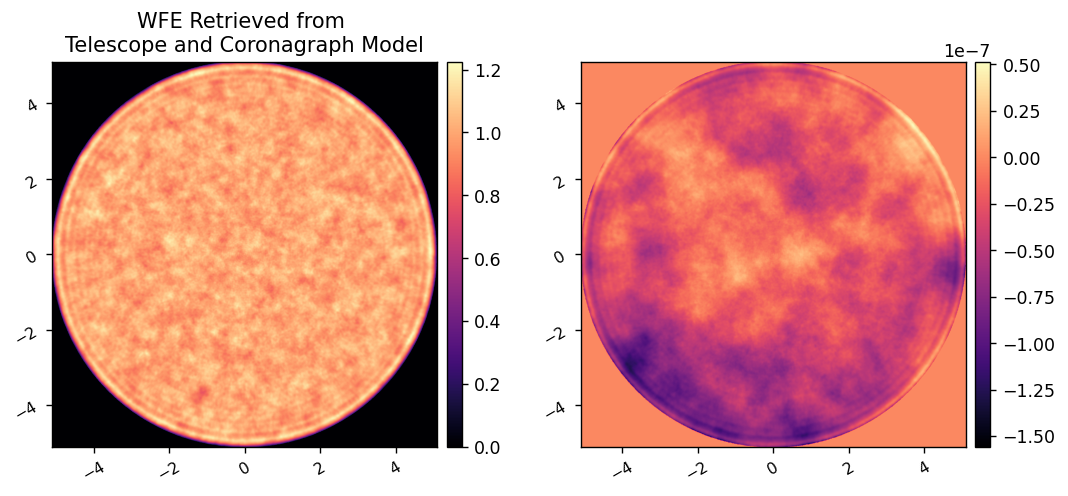

In [5]:
import numpy as np
import astropy.units as u
from astropy.io import fits
from matplotlib.patches import Rectangle, Circle
from pathlib import Path
from IPython.display import clear_output
from importlib import reload

import poppy
import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = False

import warnings
warnings.filterwarnings("ignore")

import apra_pop_models
import apra_pop_models.fraunhofer_coro_poppy as fraunhofer
from apra_pop_models.math_module import xp, _scipy, ensure_np_array

from apra_pop_models.imshows import *

pupil_diam = 10.2*u.mm
wavelength_c = 650e-9*u.m

vortex = apra_pop_models.agpm.IdealAGPM(name='VVC', wavelength=wavelength_c, charge=6)
focal_ratio = 350/500 # focal lengths of relay OAPs from DM pupil to 
lyot_diam = 0.85 * pupil_diam
lyot_stop = poppy.CircularAperture(name='Lyot Stop', radius=lyot_diam/2) # adjust by the ratio of focal lengths

# Load in the pupil plane wfe from the compact model of the coronagraph
wfe_fits = fits.open('../phase-retrieval-data/post_fpm_pupil_wfe.fits')
coro_wfe = wfe_fits[0].data
wfe_pxscl = wfe_fits[0].header['PIXELSCL'] * u.m/u.pix
wfe_fits.close()
CORO_WFE = poppy.ArrayOpticalElement(transmission=coro_wfe[0], opd=coro_wfe[1], pixelscale=wfe_pxscl,)
imshow2(CORO_WFE.amplitude, CORO_WFE.opd, 
        'WFE Retrieved from \nTelescope and Coronagraph Model',
        pxscl=wfe_pxscl.to(u.mm/u.pix))

In [6]:
final_pupil_diam = focal_ratio*10.2*u.mm
final_focal_length = 200*u.mm

fnum = final_focal_length/ final_pupil_diam
spatial_resolution = wavelength_c * fnum
spatial_resolution.to(u.um)

<Quantity 18.20728291 um>

In [17]:
model.psf_pixelscale_lamD

0.2777777777777778

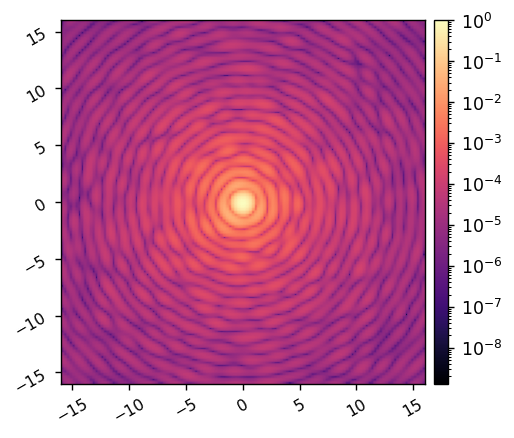

In [18]:
poppy_log.disabled = True

reload(fraunhofer)
model = fraunhofer.CORO(psf_pixelscale_lamD=1/4)

model.npix = 256
model.oversample = 4
model.npsf = 128

model.reset_dm()

model.RETRIEVED = None
model.RETRIEVED = CORO_WFE

model.im_norm = model.snap().max()
ref_im = model.snap()

imshow1(ref_im, lognorm=True, pxscl=model.psf_pixelscale_lamD)

In [12]:
model.wavelength_c

<Quantity 6.5e-07 m>

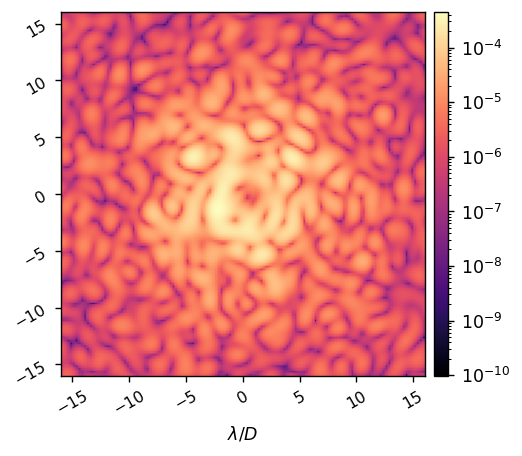

In [21]:
poppy_log.disabled = True
model.npix=256
model.oversample = 16
model.reset_dm()

model.FPM = vortex
model.LYOT = lyot_stop

model.RETRIEVED = CORO_WFE
occ_im = model.snap()

imshow1(occ_im,
        pxscl=model.psf_pixelscale_lamD, xlabel='$\lambda/D$', lognorm=True, )

In [47]:
model.Nact//2

17

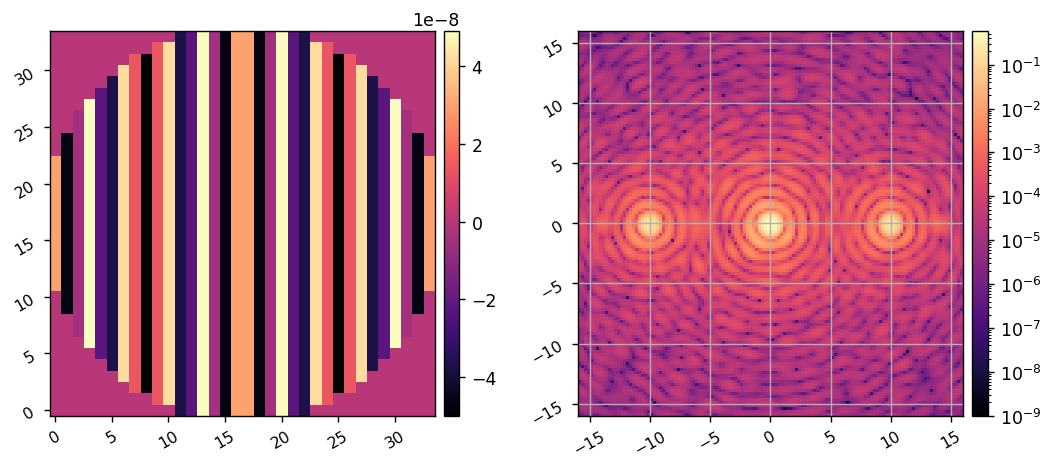

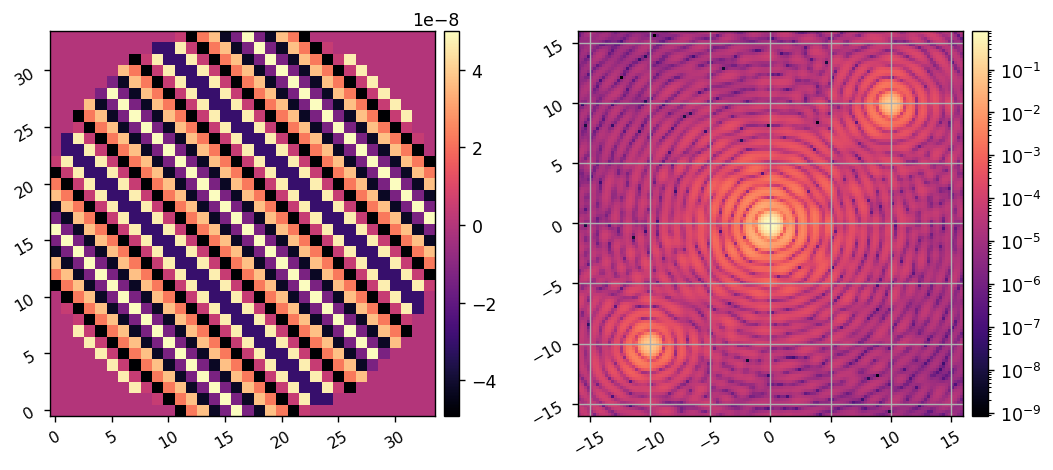

In [22]:
poppy_log.disabled = True

model.FPM = None
model.LYOT = None

Nact = model.Nact
xpp = np.arange(-model.Nact//2, model.Nact//2) + 1/2
ppx, ppy = np.meshgrid(xpp,xpp)

amp = 5e-8

separation = 10
com_1 = amp*np.cos(2*np.pi*ppx*separation/Nact)*model.dm_mask
com_2 = amp*np.cos(2*np.pi*(ppx + ppy)*separation/Nact)*model.dm_mask

model.set_dm(com_1)
im1 = model.snap()
imshow2(model.get_dm(), im1, pxscl2=model.psf_pixelscale_lamD, lognorm2=True, grid2=True)

model.set_dm(com_2)
im2 = model.snap()
imshow2(model.get_dm(), im2, pxscl2=model.psf_pixelscale_lamD, lognorm2=True, grid2=True)

In [23]:
model.reset_dm()

wfs = model.calc_wfs()

Propagating wavelength 650.000 nm.
PSF calculated in 6.450s


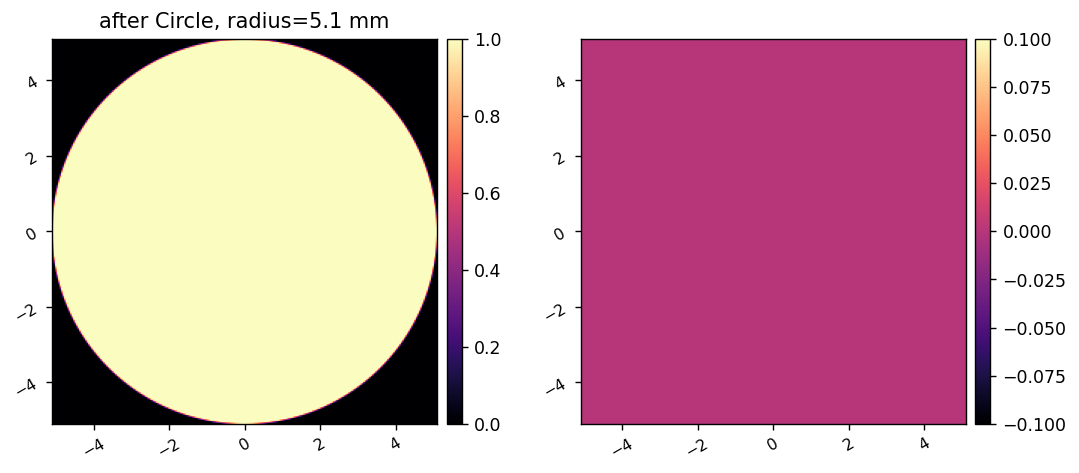

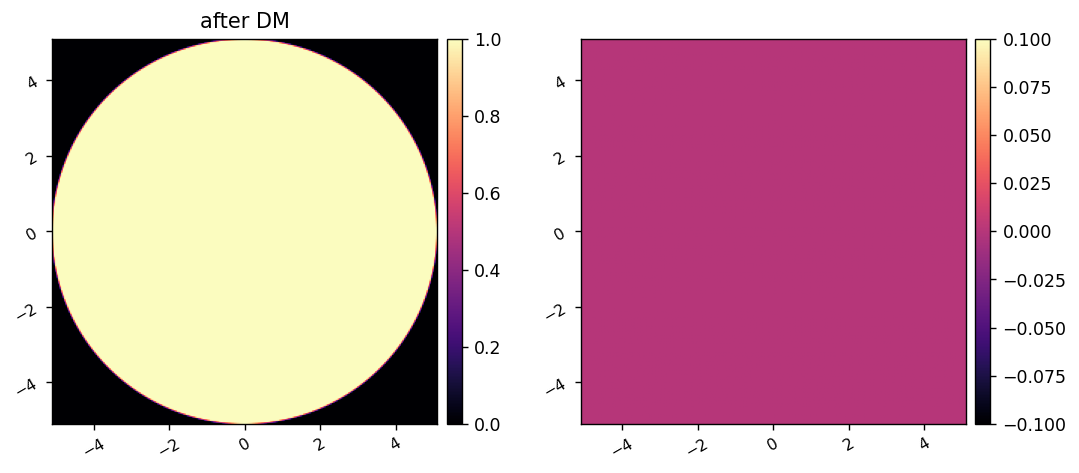

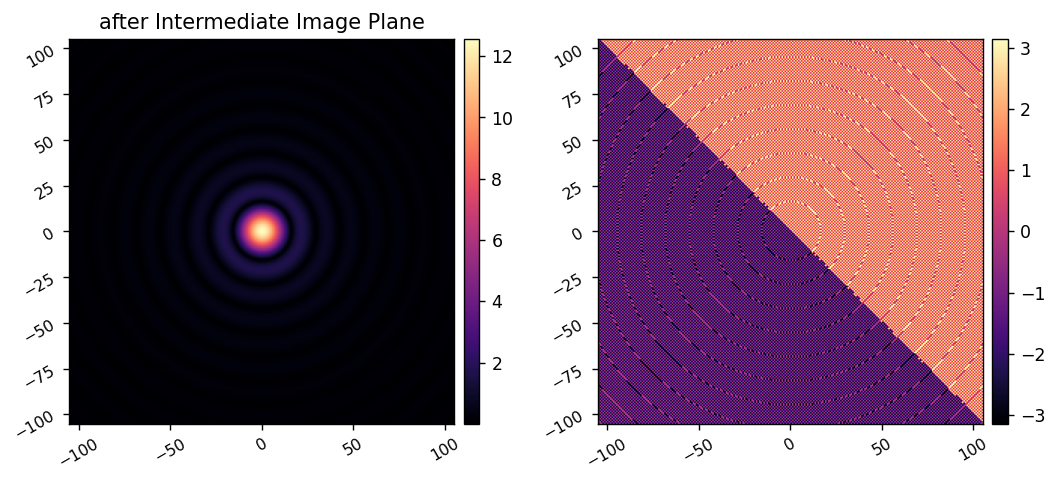

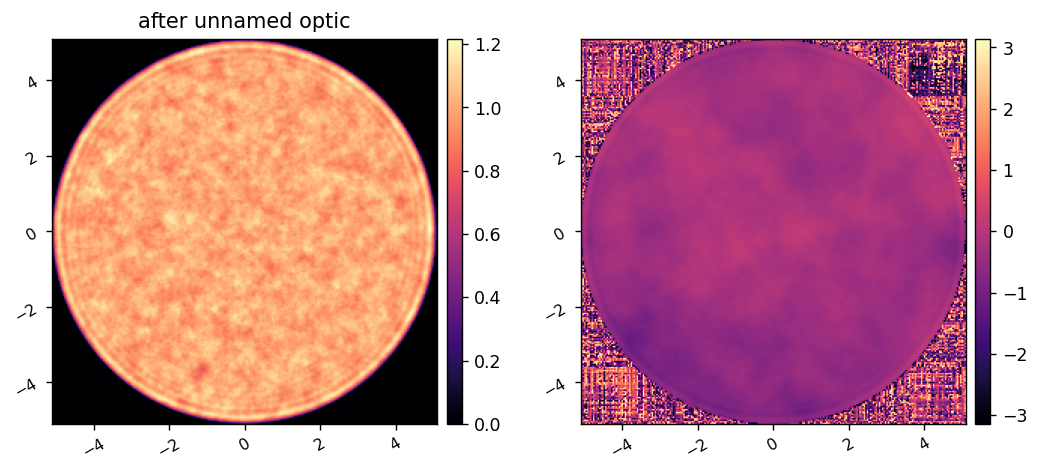

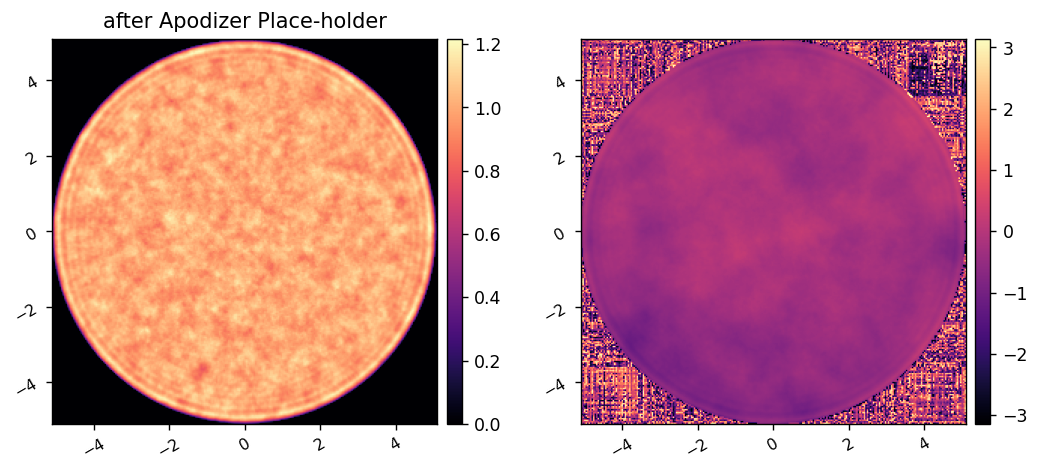

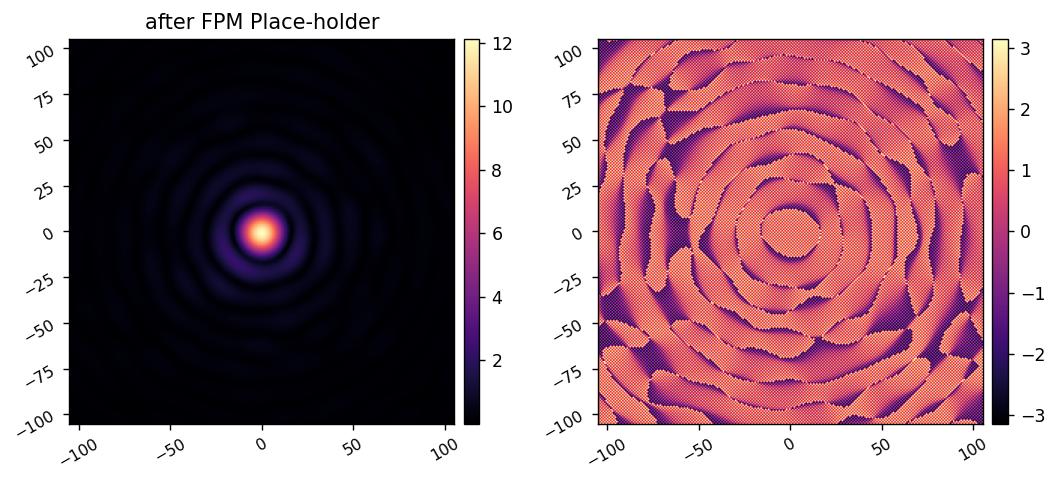

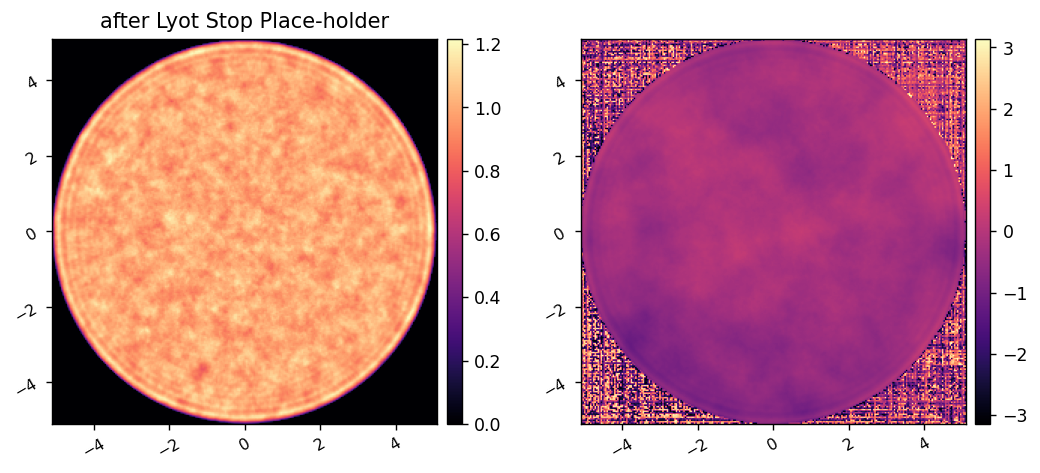

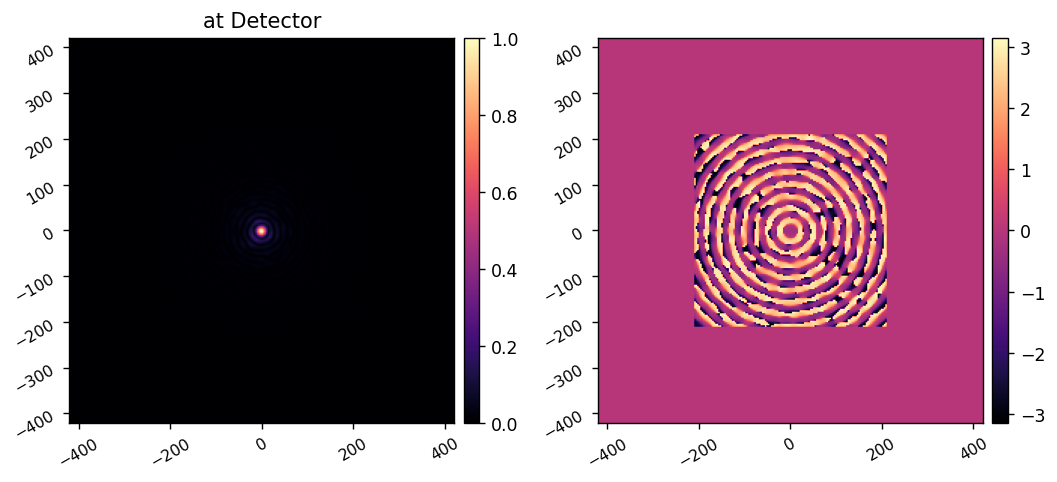

In [25]:
for i,wf in enumerate(wfs):
    imshow2(wf.amplitude, wf.phase, f'{wf.location}', npix=model.npix, pxscl=wf.pixelscale)

In [21]:
10.2 * 0.85

8.67